In [1]:
import os
import sys
from dotenv import load_dotenv
from langchain_docling import DoclingLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

/home/leapfrog/Desktop/docury_server/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
load_dotenv()

True

### PDF

In [4]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

pdf_loader = DoclingLoader(file_path="../data/uploads/transfomer_paper.pdf")
pdf_documents = pdf_loader.load()
pdf_chunks = text_splitter.split_documents(pdf_documents)

2025-12-17 16:32:44,454 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-12-17 16:32:44,535 - INFO - Going to convert document batch...
2025-12-17 16:32:44,536 - INFO - Initializing pipeline for StandardPdfPipeline with options hash e15bc6f248154cc62f8db15ef18a8ab7
2025-12-17 16:32:44,563 - WARNING - The plugin langchain_docling will not be loaded because Docling is being executed with allow_external_plugins=false.
2025-12-17 16:32:44,564 - INFO - Loading plugin 'docling_defaults'
2025-12-17 16:32:44,566 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-12-17 16:32:44,602 - WARNING - The plugin langchain_docling will not be loaded because Docling is being executed with allow_external_plugins=false.
2025-12-17 16:32:44,603 - INFO - Loading plugin 'docling_defaults'
2025-12-17 16:32:44,611 - INFO - Registered ocr engines: ['auto', 'easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-12-17 16:32:45,128 - INFO - Accelerator device: 'cuda:0'
[INFO] 2025-12-1

In [6]:
for document in pdf_documents:
    document.metadata["file_name"] = document.metadata["source"]

### URL

In [6]:
from langchain_community.document_loaders import SeleniumURLLoader

url = "https://nepalitimes.com/here-now/kangchenjunga-in-winter"

url_loader = SeleniumURLLoader(urls=[url])
url_documents = url_loader.load()
url_chunks = text_splitter.split_documents(url_documents)

In [7]:
from langchain_aws import ChatBedrock
from langchain_aws import BedrockEmbeddings

config = {
    "region_name": "us-west-1",
    "model_id": "us.amazon.nova-pro-v1:0",
    "model_kwargs": {"temperature": 0.4},
}

bedrock_model = ChatBedrock(
    region_name=config["region_name"],
    model_id=config["model_id"],
    model_kwargs=config["model_kwargs"],
)

bedrock_embeddings = BedrockEmbeddings(
    region_name=config["region_name"],
    model_id="us.cohere.embed-v4:0"
)

In [8]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator.from_langchain(
    llm = bedrock_model,
    embedding_model=bedrock_embeddings,
)

In [36]:
testset = generator.generate_with_langchain_docs(
    documents=pdf_documents[:10],
    testset_size=5
)

Applying SummaryExtractor:   0%|          | 0/9 [00:00<?, ?it/s]2025-12-17 16:55:25,200 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,222 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,226 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,238 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,241 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,251 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,262 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,263 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:55:25,275 - INFO - Using Bedrock Converse API to generate response
Applying CustomNodeFilter:   0%|          | 0/10 [00:00<?, ?it/s]2025-12-17 16:55:54,318 - WARNING - Node 7d5528fe-ebea-4603-8962-3814690ce6f3 does not have a summary. Skipping filtering.
2025-12-17 16:55:55

In [37]:
test_df = testset.to_pandas()
test_df

,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name
0,What permission does Google grant regarding th...,"[Provided proper attribution is provided, Goog...",Google grants permission to reproduce the tabl...,Dr. Alex Thompson,PERFECT_GRAMMAR,SHORT,single_hop_specific_query_synthesizer
1,"What iz da main idea behynd da ""Attentiion Is ...",[Attention Is All You Need\nAshish Vaswani ∗ G...,"The main idea behind the ""Attention Is All You...",Dr. Alex Thompson,MISSPELLED,LONG,single_hop_specific_query_synthesizer
2,How do sequence transduction models that use a...,[<1-hop>\n\nAbstract\nThe dominant sequence tr...,Sequence transduction models that use attentio...,NaN,NaN,NaN,multi_hop_abstract_query_synthesizer
3,"How did the research team from Google Brain, a...",[<1-hop>\n\nAttention Is All You Need\nAshish ...,"The research team from Google Brain, including...",NaN,NaN,NaN,multi_hop_abstract_query_synthesizer
4,What are the advantages of using self-attentio...,[<1-hop>\n\n1 Introduction\nRecurrent neural n...,The advantages of using self-attention in lang...,NaN,NaN,NaN,multi_hop_specific_query_synthesizer
5,How does the decoder in the Transformer model ...,[<1-hop>\n\nAbstract\nThe dominant sequence tr...,The decoder in the Transformer model architect...,NaN,NaN,NaN,multi_hop_specific_query_synthesizer


In [38]:
test_df.to_csv("testdata.csv", index=False)

In [39]:
from app.services.vector import VectorService
# full_chunks = pdf_chunks + url_chunks

vector_service = VectorService(store_dir="../data/vectorstore")
vector_service.add_documents(pdf_chunks)

2025-12-17 16:58:22,668 - INFO - Successfully invoked model us.cohere.embed-v4:0. ResponseMetadata: {'RequestId': '99952af9-bb04-4168-9097-51ba68cc140d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 17 Dec 2025 11:13:22 GMT', 'content-type': 'application/json', 'content-length': '1526042', 'connection': 'keep-alive', 'x-amzn-requestid': '99952af9-bb04-4168-9097-51ba68cc140d', 'x-amzn-bedrock-invocation-latency': '2583', 'x-amzn-bedrock-input-token-count': '12381'}, 'RetryAttempts': 0}


In [40]:
retriever = vector_service.get_retriever()

In [41]:
similar_docs = [doc.page_content for doc in retriever.invoke("Under what conditions does Google grant permission to reproduce the tables and figures in their papers?")]
similar_docs

2025-12-17 16:59:03,332 - INFO - Successfully invoked model us.cohere.embed-v4:0. ResponseMetadata: {'RequestId': 'b390e42a-3374-437e-a344-bae4c0d82bba', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 17 Dec 2025 11:14:03 GMT', 'content-type': 'application/json', 'content-length': '19478', 'connection': 'keep-alive', 'x-amzn-requestid': 'b390e42a-3374-437e-a344-bae4c0d82bba', 'x-amzn-bedrock-invocation-latency': '218', 'x-amzn-bedrock-input-token-count': '17'}, 'RetryAttempts': 0}


['Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.',
 'Abstract\n∗ Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head attention and the parameter-free position representation and became the other person involved in nearly every detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and tensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and efficient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and implementing tensor2tensor, re

In [18]:
from app.services.rag import RAGService

In [42]:
rag = RAGService(store_dir="../data/vectorstore")
response = rag.ask_question(question="hello", session_id="abc-xyz")
response

2025-12-17 16:59:14.411 | INFO     | app.services.rag:retriever:62 - Searching vector store
2025-12-17 16:59:16,101 - INFO - Successfully invoked model us.cohere.embed-v4:0. ResponseMetadata: {'RequestId': '2aa2f6dd-b73a-4c42-98f8-368d1926b7e5', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 17 Dec 2025 11:14:15 GMT', 'content-type': 'application/json', 'content-length': '19354', 'connection': 'keep-alive', 'x-amzn-requestid': '2aa2f6dd-b73a-4c42-98f8-368d1926b7e5', 'x-amzn-bedrock-invocation-latency': '261', 'x-amzn-bedrock-input-token-count': '1'}, 'RetryAttempts': 0}
2025-12-17 16:59:16,121 - INFO - Using Bedrock Converse API to generate response
2025-12-17 16:59:18,130 - WARNING - Error in RootListenersTracer.on_chain_end callback: ValueError("Expected str, BaseMessage, list[BaseMessage], or tuple[BaseMessage]. Got answer='Hello! How can I assist you today?' is_found=False.")
2025-12-17 16:59:18.236 | INFO     | app.services.rag:retriever:65 - Searching Wikipedia
/home/leapfr

'Hello! How can I assist you today?'

In [43]:
questions = test_df["user_input"].to_list()
ground_truth = test_df["reference"].to_list()

In [44]:
from datasets import Dataset

In [45]:
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag.ask_question(question=query, session_id="abc-xyz"))
    data["contexts"].append([doc.page_content for doc in retriever.invoke(query)])

2025-12-17 17:00:02.474 | INFO     | app.services.rag:retriever:62 - Searching vector store
2025-12-17 17:00:02,903 - INFO - Successfully invoked model us.cohere.embed-v4:0. ResponseMetadata: {'RequestId': 'f9ddd49c-7199-44c0-a2ab-ef539b98b955', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 17 Dec 2025 11:15:02 GMT', 'content-type': 'application/json', 'content-length': '19480', 'connection': 'keep-alive', 'x-amzn-requestid': 'f9ddd49c-7199-44c0-a2ab-ef539b98b955', 'x-amzn-bedrock-invocation-latency': '149', 'x-amzn-bedrock-input-token-count': '16'}, 'RetryAttempts': 0}
2025-12-17 17:00:02,920 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:04,350 - WARNING - Error in RootListenersTracer.on_chain_end callback: ValueError('Expected str, BaseMessage, list[BaseMessage], or tuple[BaseMessage]. Got answer="Google grants permission to reproduce the tables and figures in their paper solely for use in journalistic or scholarly works, provided proper attribution

In [46]:
dataset = Dataset.from_dict(data)

In [47]:
dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 6
})

In [48]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision
)

In [49]:
metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
]

embeddings = FastEmbedEmbeddings(
            model="BAAI/bge-small-en-v1.5"
        )

In [50]:
result = evaluate(
    dataset=dataset,
    metrics=metrics,
    llm=bedrock_model,
    embeddings=bedrock_embeddings,
)

Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]2025-12-17 17:00:53,097 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,110 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,126 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,128 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,141 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,145 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,152 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,154 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,166 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,183 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,187 - INFO - Using Bedrock Converse API to generate response
2025-12-17 17:00:53,200 - INFO - Using Bedrock Converse API

In [51]:
result_df = result.to_pandas()
result_df

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision
0,What permission does Google grant regarding th...,"[Provided proper attribution is provided, Goog...",Google grants permission to reproduce the tabl...,Google grants permission to reproduce the tabl...,1.000000,0.859483,1.0,1.000000
1,"What iz da main idea behynd da ""Attentiion Is ...",[Attention Is All You Need\nAshish Vaswani ∗ G...,The main idea behind the 'Attention Is All You...,"The main idea behind the ""Attention Is All You...",1.000000,0.836778,1.0,0.500000
2,How do sequence transduction models that use a...,[2 Background\nEnd-to-end memory networks are ...,Sequence transduction models that use attentio...,Sequence transduction models that use attentio...,1.000000,0.878713,0.6,0.916667
3,"How did the research team from Google Brain, a...",[Attention Is All You Need\nAshish Vaswani ∗ G...,The research team from Google Brain utilized t...,"The research team from Google Brain, including...",0.714286,0.838732,0.6,0.500000
4,What are the advantages of using self-attentio...,[2 Background\nEnd-to-end memory networks are ...,The advantages of using self-attention in lang...,The advantages of using self-attention in lang...,1.000000,0.938481,1.0,0.833333
5,How does the decoder in the Transformer model ...,[The dominant sequence transduction models are...,The decoder in the Transformer model architect...,The decoder in the Transformer model architect...,0.750000,0.900402,1.0,1.000000


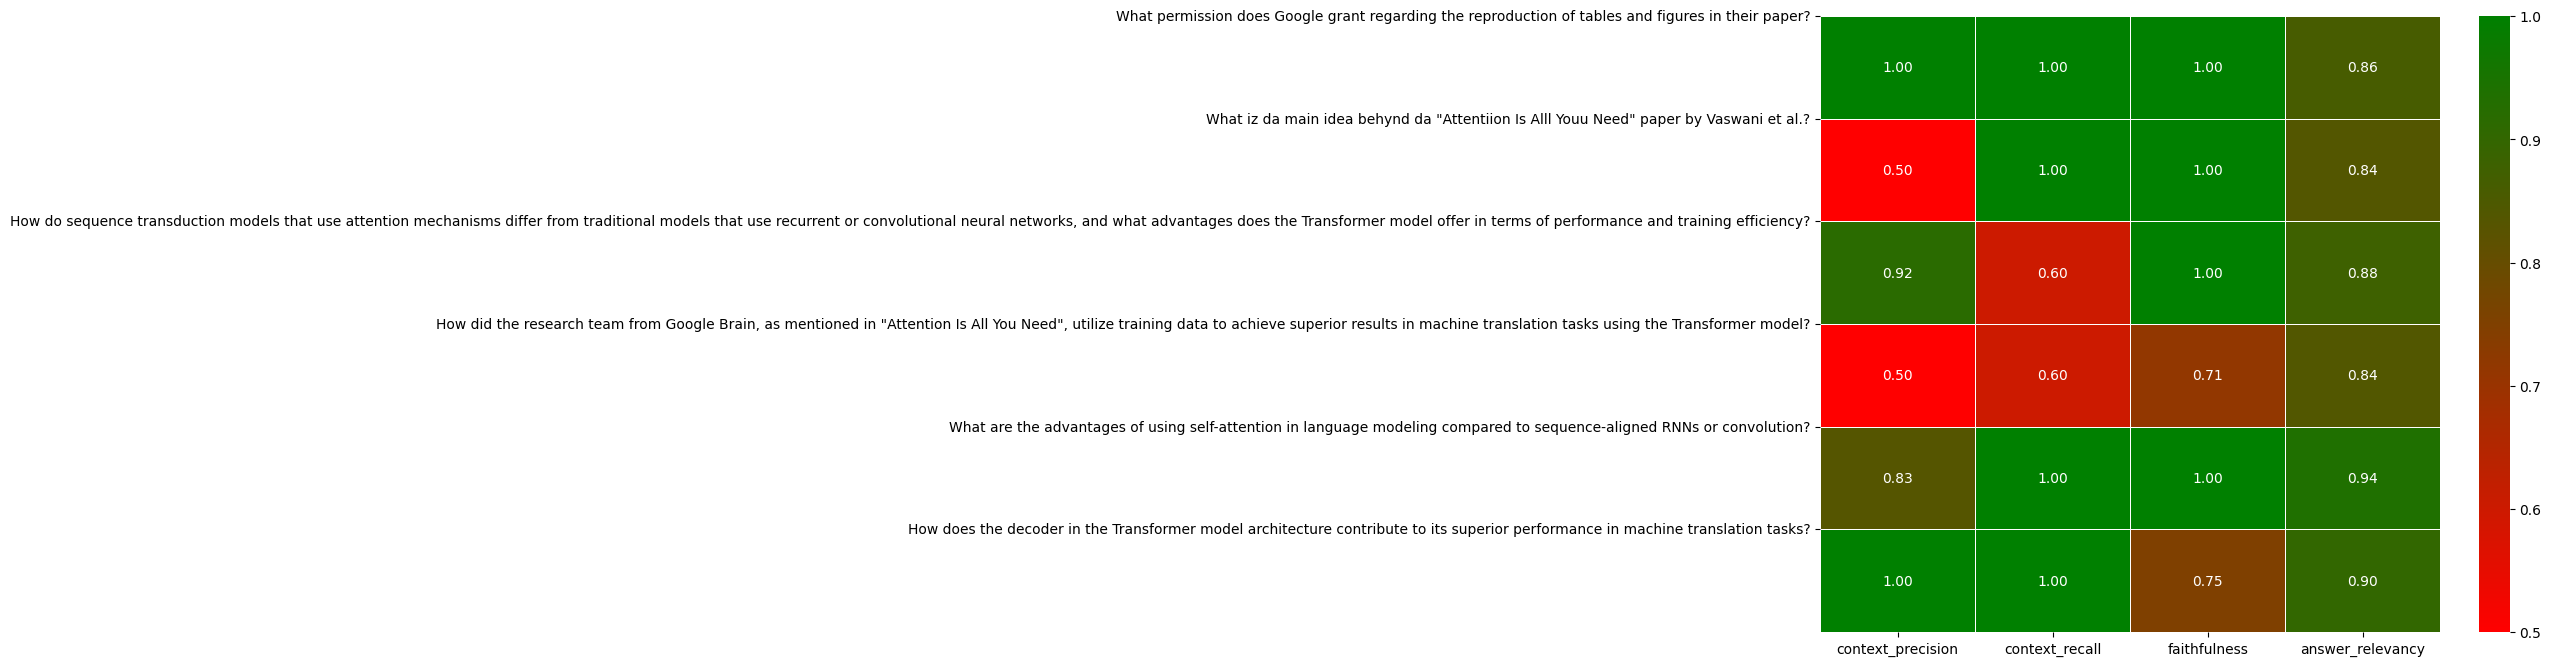

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[["context_precision", "context_recall", "faithfulness", "answer_relevancy"]]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df["user_input"])), labels=df["user_input"], rotation=0)
plt.show()